In [3]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import pickle
import sys
import networkx as nx
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram


In [4]:
class inv_Tracker():
    """Simula el detector Pixel del CMS en el HL-LHC.
    
        Args:
            
            r_max: distancia en la coordenada radial del último detector
            r_min: distancia en la coordenada radial del primer detector
            r_paso: distancia entre detectores
            h: longitud en el eje Z del Pixel
    """
    def __init__(self,capas,r_min,r_max,h):
        self.capas=capas
        self.r_min=r_min #2.5
        self.r_max=r_max #10
        r_paso=(self.r_max-self.r_min)/3
        self.h=h #60

    def detects(self, trayec, point):
        """Proporciona los puntos de corte de la traza dada con el detector i.
            Cordenadas cilíndricas: (phi, z, detector)
            
            Args:
            
                trayec: Vector director de la traza(phi,z), se toma ese punto como si estuviera en el último
                anillo de detección: (phi, z, 4).
                point: Punto de partida de la traza en la dirección del beam (z), que en nuestro vector sería 
                (*,z,0)
                traza: numerador de traza, para posterior análisis
                
            Returns:
            
                coord: Matriz con los hits en cada detector. Se incluye error en phi y z.(phi,z,detector),
                el error muestra la incapacidad de calcular el punto exacto por el que pasa la traza, hay que añadir
                la distribución que tendría en la realidad.
        """
        
        coord = np.zeros( (capas, 3) ) # (phi, z, detector)
        for k in range(capas):
            error=np.random.normal(0,0.0001)
            
            coord[k][0]=trayec[0]+error
            coord[k][1]=point+(trayec[1]-point)/self.r_max*(self.r_min+r_paso*k)
            coord[k][2]=k+1
            
        return coord

In [24]:

# Problema que se va a resolver
data_aux=np.array([
                    [ 5.55097245e+00, -2.17757762e+00,  1.00000000e+00],
                    [ 3.14500839e+00, 4.84334379e+00,  1.00000000e+00],
                    [ 5.55082614e+00, -4.35515524e+00,  2.00000000e+00],
                    [ 3.14476739e+00, 3.68668758e+00,  2.00000000e+00],
                    [ 5.55095389e+00, -6.53273286e+00,  3.00000000e+00],
                    [ 3.14493028e+00, 2.53003137e+00,  3.00000000e+00],
                    [ 5.55091827e+00, -8.71031048e+00,  4.00000000e+00],
                    [ 3.14490154e+00, 4.37337516e+00,  4.00000000e+00],
                    [ 5.55089279e+00, -10.8878881e+00,  5.00000000e+00],
                    [ 3.14495585e+00, 4.21671896e+00,  5.00000000e+00]])

hits_por_capa=2
capas=5
r_min=20
r_max=100
r_paso=(r_max-r_min)/(capas-1)
h=60.

In [29]:
class Event():
    
    """ Simula un evento en el Pixel de manera aleatoria.
        
        Args:
            
            num: número de trazas forman el evento
            ruido: valor entre 0 y 1 que determine la cantidad de ruido
            
        
        
    """
    
    
    def __init__(self, num, ruido):
        
        self.num=num
        self.ruido=ruido


        global point_rand
        global trayec_rand
        global pos_ruido
        global pos_hits
        global data
        point_rand = np.zeros( (self.num, 1) )
        trayec_rand = np.zeros( (self.num, 2) )  
        pos_ruido = np.zeros( (int(self.num*self.ruido),3) )
        pos_hits=np.zeros( (int(self.num*capas),3) )
        for k in range(self.num):

            point_rand[k]=0

            trayec_rand[k][0]=np.random.uniform(0,2*np.pi,1)
            trayec_rand[k][1]=np.random.uniform(-h/2,h/2,1)
            pos_hits[int(capas*k):int(capas*k+capas)]=inv_Tracker(capas,r_min,r_max,h).detects(trayec_rand[k],point_rand[k])
            
        for i in range(int(self.num*self.ruido)):
            
            pos_ruido[i][0]=np.random.uniform(0,2*np.pi,1)
            pos_ruido[i][1]=np.random.uniform(-h/3,h/3,1) 

            pos_ruido[i][2]=int(np.abs((np.random.normal(0,1)))+1)
       
    
        data=np.concatenate((pos_hits,pos_ruido))
        
 
        
    def show_event(self,abrir,cerrar,azimut,cenital):
        
        """ Muestra en un plot un intervalo del evento, en radianes. El azimut y cenital se refieren a la posición del observador.

            Args:

                abrir: inicio del intervalo en phi a estudiar
                cerrar: final del intervalo en phi a estudiar
                azimut:
                cenital:

        """
        from mpl_toolkits.mplot3d import Axes3D
        import numpy as np

        import matplotlib.pyplot as plt

        fig1 = plt.figure(figsize = (20,20)) 
        env = fig1.add_subplot(111, projection='3d') 
       
        # DETECTORES
        no_values = 15
        for i in range(capas+1): # El primero es el beam

            phi_cyl = np.linspace(abrir, cerrar, no_values)
            x_walls = (r_min+(i-1)*r_paso)* np.cos(phi_cyl) 
            z_walls = np.linspace(-h/2, h/2, no_values)
            x2D_walls, z2D_walls = np.meshgrid(x_walls, z_walls)
            y2D_walls = np.sqrt((r_min+(i-1)*r_paso)**2 - x2D_walls**2)


            # Detector i
            env.plot_surface(x2D_walls, -y2D_walls, z2D_walls, color='grey', alpha=0.05)
            env.plot_surface(x2D_walls, y2D_walls, z2D_walls, color='grey', alpha=0.05)
            env.plot_wireframe(x2D_walls, y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.1)
            env.plot_wireframe(x2D_walls, -y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.1)

        # TRAZAS
      

        for k in range(self.num):
            
            x2=np.linspace(0,r_max*np.cos(pos_hits[int(capas*k)][0]),30)
            y2=np.linspace(0,r_max*np.sin(pos_hits[int(capas*k)][0]),30)
            z2=np.linspace(0,pos_hits[capas*k+capas-1][1],30)

            env.plot(x2,y2,z2)
        # PUNTOS
        # 1) Hits
        for j in range(capas*self.num):
            env.scatter((r_min+(pos_hits[j][2]-1)*r_paso)*np.cos(pos_hits[j][0]),(r_min+(pos_hits[j][2]-1)*r_paso)*np.sin(pos_hits[j][0]),pos_hits[j][1],color='k')
        # 2) Ruido
        for k in range(int(self.num*self.ruido)):
            env.scatter((r_min+(pos_ruido[k][2]-1)*r_paso)*np.cos(pos_ruido[k][0]),(r_min+(pos_ruido[k][2]-1)*r_paso)*np.sin(pos_ruido[k][0]),pos_ruido[k][1],color='r')
        
        # REPRESENTACION

        
        env.view_init(180/np.pi*cenital, 180/np.pi*azimut)


        plt.show()

    def export_event(self):
         
        file=open('/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt', 'w')
        file.write(tabulate(data, headers=['Phi', 'z', 'Detector']))

        
        file.close()
        return data
    
    def export_edges(self):
        """ Exporta el vector de aristas y las posiciones de los hits que las
            forman. Observación: Los hits deben estar ordenados
            
            En salida: 
            a: matriz (hit1,hit2,z2-z1,z1,z2,r1,r2) para utilizar en export_weights
        """
        # Información del problema a resolver

        edges=int((capas-1)*hits_por_capa**2)
        
        # Definición de las aristas como combinación de dos hits y parámetros
        a=np.zeros((edges,7))
        # Contadores para rellenar el vector a
        cont1=0
        cont2=0
        base=hits_por_capa
        for i in range(edges):
            
            a[i][[0,1]]=[cont1,base+cont2] # Hits involucrados
            a[i][2]=-data_aux[cont1][1]+data_aux[base+cont2][1] # Diferencia en z para poder calcular los ángulos de dos aristas
            a[i][[3,4,5,6]]=[data_aux[cont1][1],data_aux[base+cont2][1],data_aux[cont1][2]*r_paso,data_aux[base+cont2][2]*r_paso] # Posición de los hits
            plt.plot([data_aux[cont1][1],data_aux[base+cont2][1]],[data_aux[cont1][2]*r_paso, data_aux[base+cont2][2]*r_paso],'k--')
            plt.plot([data_aux[cont1][1],data_aux[base+cont2][1]],[data_aux[cont1][2]*r_paso, data_aux[base+cont2][2]*r_paso],'ko')

            cont2=cont2+1
            if (i+1)%hits_por_capa==0:
                cont1=cont1+1
                cont2=0
            if (i+1)%hits_por_capa**2==0:
                base=base+hits_por_capa
                
        return  a
    
    def export_weights(self,a):
        """ Exporta la matriz que define la función de coste
        
        En entrada: 
        a: matriz de aristas y posición de hits
        
        En salida:
        weights: matriz de la función de coste f(s)=s(weights)s'
        
        """
        # Información del problema a resolver
        angles=int((capas-2)*hits_por_capa**3)
        
        # Definición de la matriz de pesos y el vector de combinaciones de aristas
        weights=np.zeros((len(a[:,1]),len(a[:,1])))
        s_is_j=np.zeros((angles,3))
        
        # Elección de parámetros para los pesos  
        mult=25 # Magnitud del término de los cosenos
        TOL=0.175 # Mínimo de cada coseno
        alpha=5*mult*TOL # Magnitud para la no repetición de aristas
        beta=mult*TOL/5 # Magnitud para evitar las aristas sueltas
        k=[9,7,5,1,1] # Cambios en la pendiente del coseno (impar)
        zeta=2 # Exponente del término de origen (par)
        eta= 0.025 # Magnitud del término de origen
        
        # Contadores para rellenar la matriz
        cont1=0
        cont2=hits_por_capa**2
        nivel=hits_por_capa**2-1
        pos_k=0
        
        # Llenado de la matriz con el peso para aristas sueltas 
        np.fill_diagonal(weights, beta)
        
        # Bucle sobre todas las combinaciones de aristas posibles
        for i in range(angles):
            s_is_j[i][[0,1]]=[cont1,cont2]
            # Condicional sobre la trigonometría
            if a[cont1][2]*a[cont2][2]>0:
                s_is_j[i][2]=np.pi/2+np.arctan(abs(a[cont1][2])/r_paso)+np.arctan(r_paso/abs(a[cont2][2]))
            else:
                s_is_j[i][2]=np.arctan(r_paso/abs(a[cont1][2]))+np.arctan(r_paso/abs(a[cont2][2]))
            # Pesos para medir el origen
            origen_term1=a[int(s_is_j[i][1])][4]-a[int(s_is_j[i][1])][6]*(a[int(s_is_j[i][1])][4]-a[int(s_is_j[i][0])][3])/(a[int(s_is_j[i][1])][6]-a[int(s_is_j[i][0])][5])
            origen_term2=a[int(s_is_j[i][0])][4]-a[int(s_is_j[i][0])][6]*(a[int(s_is_j[i][0])][4]-a[int(s_is_j[i][0])][3])/(a[int(s_is_j[i][0])][6]-a[int(s_is_j[i][0])][5])
            # Pesos para medir la curvatura
            weights[cont1][cont2]=mult*(np.cos(s_is_j[i][2])**k[pos_k]+1-TOL)+eta*((origen_term1)**zeta)+eta*((origen_term2)**zeta)
            weights[cont2][cont1]=mult*(np.cos(s_is_j[i][2])**k[pos_k]+1-TOL)+eta*((origen_term1)**zeta)+eta*((origen_term2)**zeta)
            if (i+1)%hits_por_capa**3==0:
                # Pesos para la no repetición de aristas
                weights[cont1-3][cont1-1]=alpha
                weights[cont1-1][cont1-3]=alpha
                weights[cont1-2][cont1]=alpha
                weights[cont1][cont1-2]=alpha
                
                nivel=nivel+hits_por_capa**2
                pos_k=pos_k+1
            if (i+1)%hits_por_capa==0:
                # Pesos para la no repetición de aristas
                weights[cont2][cont2-1]=alpha
                weights[cont2-1][cont2]=alpha
                
                cont1=cont1+1
            if (cont2+1)%hits_por_capa**2==0:
                cont2=nivel
            cont2=cont2+1

        file=open('/home/pablo/Desktop/TFG/Qiskit/VQE_weights.txt', 'w')
        file.write(tabulate(np.round(weights,3), headers=['----------------', '----------------', '----------------','----------------','----------------','----------------','----------------', '----------------', '----------------','----------------','----------------','----------------','----------------', '----------------', '----------------','----------------','----------------','----------------']))

        
        file.close()
        return weights

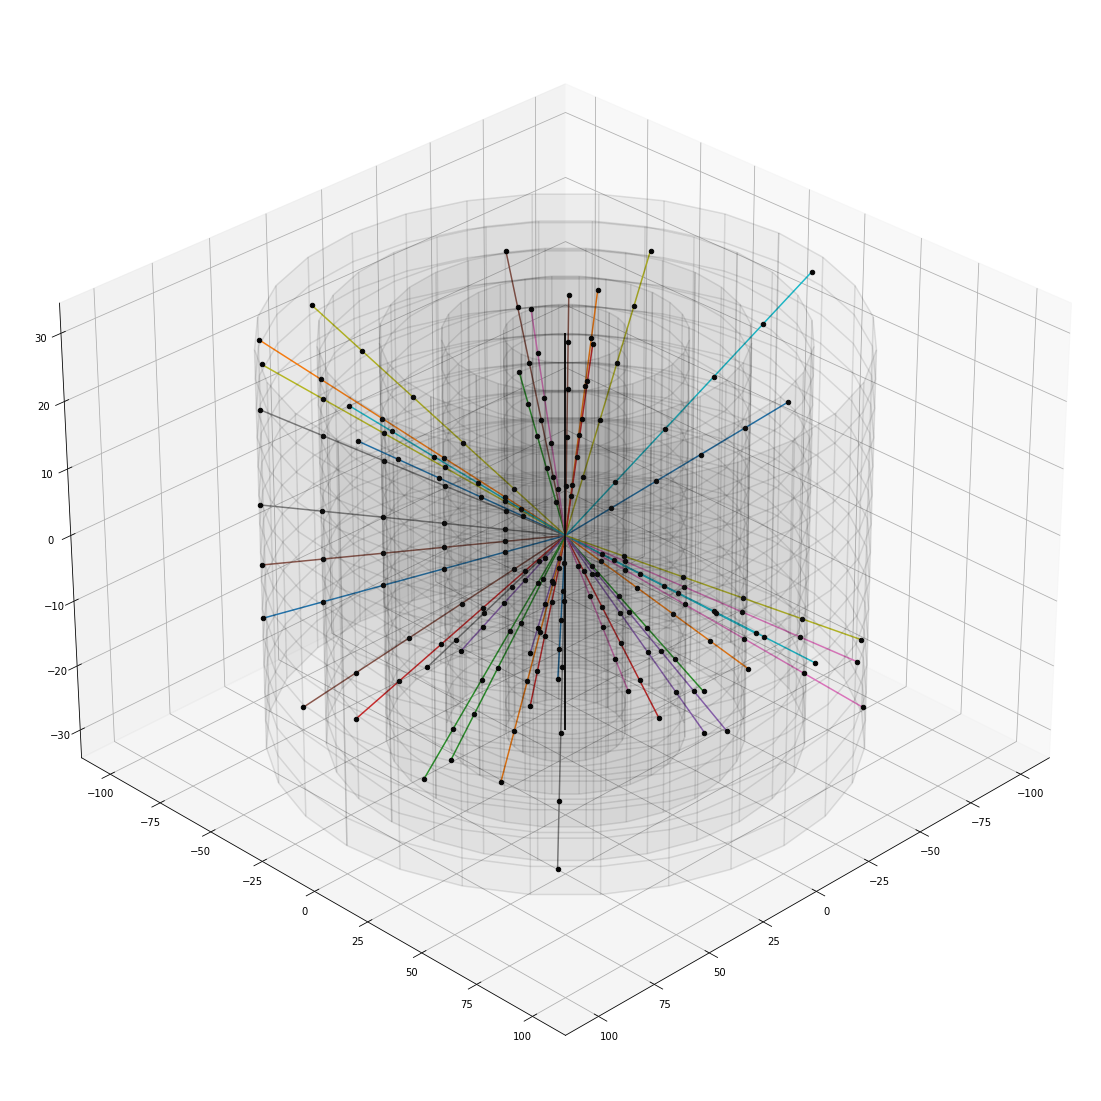

In [30]:
# De momento no está implementado para que coja los datos de este evento
event=Event(40,0)
#event.show_event(0,np.pi,np.pi/4,np.pi/6)
a=event.export_edges()

In [32]:

event.export_weights(a)

array([[ 0.875     ,  0.        , 21.875     ,  0.        , -4.375     ,
        10.98289772,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.875     ,  0.        , 21.875     ,  0.        ,
         0.        , 20.83257321,  8.18784494,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [21.875     ,  0.        ,  0.875     ,  0.        , 12.80713883,
        25.10441384,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , 21.875     ,  0.        ,  0.875     ,  0.        ,
         0.        , 13.02875321, -2.575     ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-4.375     ,  0.        , 12

In [36]:
def variational_form(theta, n, depth, mode): 
    """Forma variacional capaz de variar el autoestado de trabajo
        mediante rotaciones con puertas RY.
    
    En entrada:
        depth: número de capas de reajuste RY
        theta: (depth+1 x n) parámetros de rotación para cada qubit
            y para cada capa de reajuste RY,
        n: número de qubits,
        mode: tipo de entrelazamiento, 'linear' o 'compatible'
    En salida::
        circuit: circuito cuántico para una iteración
    """
        
    if len(theta.ravel()) != ((depth+1) * n):        
        raise ValueError("La matriz de ánguos no puede escribirse como (depth+1 x n)")

    theta.shape = (depth + 1, n)

    # Inicialización
    q = QuantumRegister(n)
    c = ClassicalRegister(n)

    # Construcción del circuito 
    circuit = QuantumCircuit(q, c)

    # Rotación inicial de todos los qubits
    for i in range(n):
        circuit.ry(theta[0,i],q[i])
    circuit.barrier()
    
    if mode=='linear':
        for j in range(depth):

            for i in range(n-1):
                circuit.cz(q[i], q[i+1])


            for i in range(n):
                circuit.ry(theta[j+1,i],q[i])
            circuit.barrier()
    elif mode=='compatible':
        for j in range(depth):
            angles=int((capas-2)*hits_por_capa**3)
            cont1=0
            cont2=hits_por_capa**2
            nivel=hits_por_capa**2-1

            # Bucle sobre todas las combinaciones de aristas posibles
            for i in range(angles):
                
                circuit.cz(q[cont1],q[cont2]) #Puertas de control sobre aristas que pueden unirse
                if (i+1)%hits_por_capa**3==0:
                    nivel=nivel+hits_por_capa**2
                if (i+1)%hits_por_capa==0:
                    cont1=cont1+1
                if (cont2+1)%hits_por_capa**2==0:
                    cont2=nivel
                cont2=cont2+1

            for i in range(n):
                circuit.ry(theta[j+1,i],q[i])
            circuit.barrier()
    
        
    # Medida final de los qubits
    circuit.measure(q, c)
    
    return circuit    

In [37]:
def cost_function(params,weights, n, depth, shots,cost = 'cost',algorithm = 'VQE',alpha= 0.5,mode='compatible'):
    """Crea el circuito cuántico con los parámetros dados, lo ejecuta shots veces y devuelve
        el coste de ese resultado.
    
    En entrada:
        params: matriz con los ángulos de reajuste,
        weights: matriz de los cosenos,
        n: número de qubits,
        depth: capas de reajuste del circuito cuántico,
        shots: evaluaciones del circuito cuántico,
        cost: función de coste que se va a utlizar, 'cost' o 'cvar'
        alpha: 'cvar' alpha parameter
        mode: tipo de entrelazamiento
    En salida:
        output: coste de la configuración de autoestados hallado con COBYLA
    """

    # Circuito de evaluación
    circuit = variational_form(params, n, depth,mode)
    
    
    backend = Aer.get_backend('qasm_simulator')

    
    # Ejecución del circuito shots veces
    job = execute(circuit, 
                  backend = backend, 
                  shots   = shots)
    results = job.result()
    
    # Autoestados 
    eigenstates = list(results.get_counts().keys())
    
    # Número de veces que aparece cada autoestado
    abundancies = list(results.get_counts().values())
    max_abundancies=np.max(abundancies)
    

    cost = 0
    for k in range(len(eigenstates)):
        # Autoestado k en forma binaria
        s = np.array([int(num) for num in eigenstates[k]])
        # Coste para el autoestado k
        cost =cost+ 0.5*s.dot(weights.dot(s)) * abundancies[k]
    output = cost / shots
 


    return output



In [38]:
import time
from scipy.optimize import minimize


def VQE(shots,weights,n,depth,final_eval_shots, cost, alpha = 0.5,algorithm='VQE',theta = 1,mode='compatible'):
    """ Resuelve el problema de optimización.
    .    
    
    En entrada:
    shots: evaluaciones del circuito cuántico,
    weights: matriz de pesos,
    n: número de qubits,
    depth:número de reajustes en el circuito cuántico,
    final_eval_shots: número de pasos para la ejecución del circuito final,
    cost: the cost function to be used. It can be: 
     - 'cost': mean value of all measured eigenvalues
     - 'cvar': conditional value at risk = mean of the
               alpha*shots lowest eigenvalues,
    alpha: 'cvar' alpha parameter
    algorithm: the optimization algorithm to be used (VQE or QAOA),
    theta: información sobre los angulos iniciales. Valor 1 si se utliza la rotacion RY
    mode: tipo de entrelazamiento
    
    En salida:
    elapsed_time: segundos que tarda en optimizar
    counts: distribución de estados
    n_func_evaluations: number of evaluations of the cost function
    final_cost: the cost function of the optimal circuit.
    
    """
    # Do this only if no initial parameters have been given
    if isinstance(theta, (int)):
        # Create the rotation angles for the ansatz
        theta_0       = np.repeat(np.pi/2, n)
        theta_0.shape = (1, n)
        theta_1       = np.zeros((depth, n))
        theta         = np.concatenate((theta_0, theta_1), axis = 0) 
    
    # Time starts with the optimization
    start_time = time.time()

    # print("method: {0}".format(method))

    # Classical optimizer tuning - COBYLA
    res = minimize(fun     = cost_function, 
                   x0      = theta.ravel(),       # the 'params' argument of 'cost_function_cobyla'
                   method  = 'cobyla',            # we want to use the COBYLA optimization algorithm
                   options = {'maxiter': 1000},  # maximum number of iterations
                   tol     = 0.0001,              # tolerance or final accuracy in the optimization 
                   args    = (weights, 
                              n, 
                              depth, 
                              shots,
                              cost,
                              algorithm,
                              alpha,
                              mode))    # the arguments of 'cost_function', except 'params'

    # Time stops when the optimization stopshttps://qiskit.org/
    end_time = time.time()
    
    # Total time taken for the optimization
    elapsed_time = end_time - start_time 

    # Number of cost function evaluations during the optimization
    n_func_evaluations = res.nfev

    # Obtain the output distribution using the final parameters

    optimal_circuit = variational_form(res.x, n, depth,mode)

    backend = Aer.get_backend('qasm_simulator')


    # Get the results from the circuit with the optimized parameters    
    counts = execute(optimal_circuit, 
                     backend, 
                     shots = final_eval_shots).result().get_counts(optimal_circuit)
    
    # The optimized rotation angles
    optimal_angles = res.x

    print(counts)
    
    # The cost function of the optimal circuit
    final_cost = res.fun
    
    return counts, final_cost, n_func_evaluations


In [39]:

counts, final_cost, n_func_evaluations = VQE(shots=5000, weights=event.export_weights(a), n=16,depth=1,final_eval_shots=5000,cost='cost',alpha=0.5,algorithm='VQE',theta=1,mode='compatible')
print(final_cost)


{'1110100010100000': 1, '0101000100010000': 1, '0000001100010001': 1, '0100000110001010': 1, '0011000110011000': 1, '0110000100000101': 1, '0000010100000101': 1, '0000000010101001': 1, '1100100000100000': 1, '1000100010010010': 1, '0000000110011101': 2, '0100001000000000': 1, '0000001110001000': 2, '0010000110010010': 1, '0010001100000000': 4, '1100100010000001': 1, '0100000000010000': 1, '0100001100010001': 2, '0011001100000000': 1, '0000000000010010': 1, '0001001100010101': 1, '0000000101000000': 1, '0010010010010101': 1, '1000001000000000': 1, '0100000100000010': 1, '1100100100010101': 1, '0000001000010000': 1, '0001010110010000': 1, '0000010110000010': 1, '0010001100010000': 2, '0000010110000001': 1, '0001010000010000': 1, '0010010100000001': 1, '0100000000100001': 2, '0010000100010100': 2, '0000010100010101': 1, '0001000010001000': 1, '0000010100010100': 1, '0000000100010111': 1, '0001001000000000': 3, '0000001100100101': 1, '0001000100000101': 1, '0010000100110001': 2, '000000010

In [40]:
print(n_func_evaluations)

633


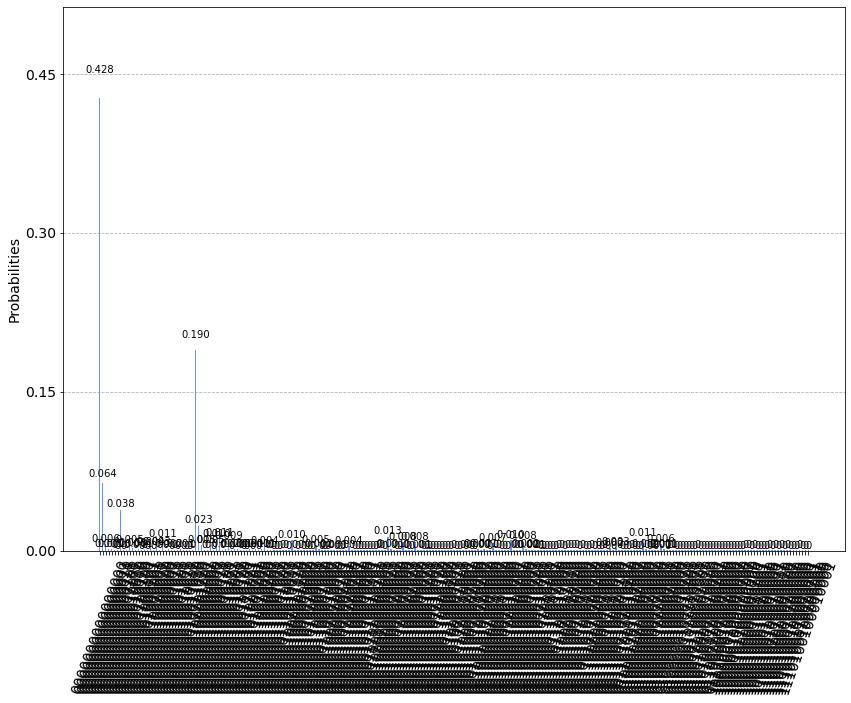

In [41]:
plot_histogram(counts, figsize=(14, 10))

In [43]:
def best_candidate_finder(results_dict, 
                          weights):
        
    # the eigenstates obtained by the evaluation of the circuit
    eigenstates = list(results_dict.keys())
        
    # initialize the cost function
    min_cost = 0
    best_candidate = 0
    
    for k in range(len(eigenstates)):
        # ndarray of the digits extracted from the eigenstate string 
        x = np.array([int(num) for num in eigenstates[k]])
        # Cost function of to the k-th eigenstate
        cost = 0.5*x.dot(weights.dot(x))
        if cost <= min_cost:
            print(cost, x)
            min_cost = cost
            best_candidate = x
    
    return best_candidate

best_candidate=best_candidate_finder(counts,event.export_weights(a) )

-5.682821033503292 [0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0]
-6.5625 [1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1]
-7.0 [1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0]
-7.0 [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1]
-7.4375 [1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]


In [44]:
x=np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
weights=event.export_weights(a)
print(0.5*x.dot(weights.dot(x)))

-11.375


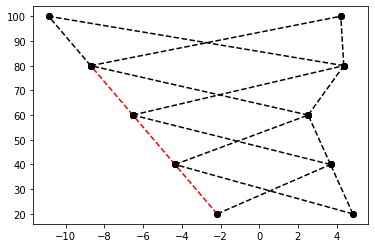

In [45]:


for i in range(len(best_candidate)):
    if best_candidate[i]==1:
        plt.plot([data_aux[int(a[i][0])][1],data_aux[int(a[i][1])][1]],[data_aux[int(a[i][0])][2]*r_paso, data_aux[int(a[i][1])][2]*r_paso],'r--')
    else:
        plt.plot([data_aux[int(a[i][0])][1],data_aux[int(a[i][1])][1]],[data_aux[int(a[i][0])][2]*r_paso, data_aux[int(a[i][1])][2]*r_paso],'k--')
    plt.plot([data_aux[int(a[i][0])][1],data_aux[int(a[i][1])][1]],[data_aux[int(a[i][0])][2]*r_paso, data_aux[int(a[i][1])][2]*r_paso],'ko')
